In [1]:
from ortools.sat.python import cp_model
from pprint import pprint
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def display_schedule_as_table(schedules, resources, date_range):
    # Create a dictionary to map resource and date to a 1 or 0
    schedule_table = {r['id']: {d: 0 for d in date_range} for r in resources}
    for r_id, _, date in schedules:
        schedule_table[r_id][date] = 1

    # Convert the schedule table to a NumPy array for visualization
    data = np.array([[schedule_table[r_id][d] for d in date_range] for r_id in [r['id'] for r in resources]])

    # Plot the table
    fig, ax = plt.subplots(figsize=(len(date_range) * 2, len(resources) * 0.8))
    ax.set_axis_off()

    # Create the table
    table_colors = np.where(data == 1, 'red', 'beige')  # Red for scheduled, beige for unscheduled
    table = ax.table(cellText=data, 
                     rowLabels=[f"Resource {r['id']}" for r in resources], 
                     colLabels=date_range,
                     cellColours=table_colors,
                     loc='center',
                     cellLoc='center')

    # Style the table
    table.scale(1, 2)  # Adjust row and column scaling
    table.auto_set_font_size(False)
    table.set_fontsize(12)

    # Add borders and rotate column labels
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor('black')  # Add borders
        if i == 0:  # Header row
            cell.set_text_props(rotation=0, ha='center', va='bottom')  # Rotate x-axis labels

    # Show the table
    plt.tight_layout()
    plt.show()


In [3]:

# Generate input data
resources = [
    {"id": i, "skills": {"Skill_A", "Skill_B"}, "cost_per_day": random.randint(100, 300)}
    for i in range(1, 11)
]

jobs = [
    {
        "id": i,
        "required_skills": {"Skill_A"} if i % 2 == 0 else {"Skill_B"},
        "priority": "high" if i % 3 == 0 else "low",
        "customer_priority": "high" if i % 5 == 0 else "low",
        "resource_count": random.randint(1, 3),
    }
    for i in range(1, 51)
]


In [4]:
# # Define the input data
# resources = [
#     {"id": 1, "skills": {"A", "B"}, "cost_per_day": 200},
#     {"id": 2, "skills": {"A"}, "cost_per_day": 150},
#     {"id": 3, "skills": {"B"}, "cost_per_day": 180},
# ]

# jobs = [
#     {"id": 1, "required_skills": {"A"}, "priority": "high", "customer_priority": "high", "resource_count": 1},
#     {"id": 2, "required_skills": {"B"}, "priority": "low", "customer_priority": "low", "resource_count": 1},
#     {"id": 3, "required_skills": {"A", "B"}, "priority": "high", "customer_priority": "low", "resource_count": 2},
# ]

In [5]:
date_range = [f"2024-12-{i}" for i in range(16, 21)]  # Workweek

In [6]:
def filter_infeasible_jobs(jobs, resources, date_range):
    feasible_jobs = []
    for job in jobs:
        # Check skill compatibility
        compatible_resources = [
            r for r in resources if job["required_skills"].issubset(r["skills"])
        ]
        
        # Check resource count feasibility
        if len(compatible_resources) < job["resource_count"]:
            print(f"Job {job['id']} removed: Not enough compatible resources.")
            continue
        
        # Check scheduling feasibility
        max_assignments = len(compatible_resources) * len(date_range)
        if max_assignments < job["resource_count"]:
            print(f"Job {job['id']} removed: Not enough dates to assign required resources.")
            continue
        
        # If all checks pass, the job is feasible
        feasible_jobs.append(job)
    
    return feasible_jobs

# Filter infeasible jobs
jobs = filter_infeasible_jobs(jobs, resources, date_range)

# Assign priority ranks using decision tree rules
for job in jobs:
    if job["priority"] == "high":
        job["priority_rank"] = 1
    elif job["customer_priority"] == "high":
        job["priority_rank"] = 2
    else:
        job["priority_rank"] = 3
        
pprint(jobs)
pprint(resources)

[{'customer_priority': 'low',
  'id': 1,
  'priority': 'low',
  'priority_rank': 3,
  'required_skills': {'Skill_B'},
  'resource_count': 3},
 {'customer_priority': 'low',
  'id': 2,
  'priority': 'low',
  'priority_rank': 3,
  'required_skills': {'Skill_A'},
  'resource_count': 2},
 {'customer_priority': 'low',
  'id': 3,
  'priority': 'high',
  'priority_rank': 1,
  'required_skills': {'Skill_B'},
  'resource_count': 1},
 {'customer_priority': 'low',
  'id': 4,
  'priority': 'low',
  'priority_rank': 3,
  'required_skills': {'Skill_A'},
  'resource_count': 2},
 {'customer_priority': 'high',
  'id': 5,
  'priority': 'low',
  'priority_rank': 2,
  'required_skills': {'Skill_B'},
  'resource_count': 3},
 {'customer_priority': 'low',
  'id': 6,
  'priority': 'high',
  'priority_rank': 1,
  'required_skills': {'Skill_A'},
  'resource_count': 2},
 {'customer_priority': 'low',
  'id': 7,
  'priority': 'low',
  'priority_rank': 3,
  'required_skills': {'Skill_B'},
  'resource_count': 2},
 {'

In [19]:
def solve_for_priority_rank(jobs, resources, date_range, priority_rank):
    model = cp_model.CpModel()

    # Filter jobs by the given priority rank
    jobs_to_schedule = [job for job in jobs if job["priority_rank"] == priority_rank]

    # Decision variables
    x = {}  # Resource assignment: x[(resource, job, date)]
    y = {}  # Job assignment: y[(job, date)]

    for r in resources:
        for j in jobs_to_schedule:
            for d in date_range:
                x[(r["id"], j["id"], d)] = model.NewBoolVar(f"x_{r['id']}_{j['id']}_{d}")
        for j in jobs_to_schedule:
            for d in date_range:
                y[(j["id"], d)] = model.NewBoolVar(f"y_{j['id']}_{d}")

    # Objective function: Minimize cost
    objective_terms = []
    for r in resources:
        for j in jobs_to_schedule:
            for d in date_range:
                objective_terms.append(r["cost_per_day"] * x[(r["id"], j["id"], d)])

    model.Minimize(sum(objective_terms))

    # Constraints
    # Each job must have the required number of resources on the assigned date
    for j in jobs_to_schedule:
        # Ensure the job is assigned on one and only one date
        model.Add(sum(y[(j["id"], d)] for d in date_range) == 1)

        # Link y[j, d] to resource assignments
        for d in date_range:
            model.Add(
                sum(x[(r["id"], j["id"], d)] for r in resources if j["required_skills"].issubset(r["skills"]))
                == j["resource_count"] * y[(j["id"], d)]
            )

    # Each resource can only be assigned to one job per day
    for r in resources:
        for d in date_range:
            model.Add(sum(x[(r["id"], j["id"], d)] for j in jobs_to_schedule) <= 1)

    # Solve the model
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = True
    status = solver.Solve(model)

    # Collect results
    results = []
    diagnostics = {}
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        diagnostics['objective_value'] = solver.ObjectiveValue()
        diagnostics['best_objective_bound'] = solver.BestObjectiveBound()
        print(f"Best objective value (current solution): {solver.ObjectiveValue()}")
        print(f"Best bound (worst possible objective still achievable): {solver.BestObjectiveBound()}")
        for r in resources:
            for j in jobs_to_schedule:
                for d in date_range:
                    if solver.Value(x[(r["id"], j["id"], d)]):
                        results.append((r["id"], j["id"], d))
    else:
        print(f"No feasible solution found for priority rank {priority_rank}.")

    return results, diagnostics

# Solve for each priority rank and aggregate results
all_schedules = []
all_diagnostics = []
for pr in range(1, 4):  # Priority ranks 1, 2, and 3
    print(f"Scheduling jobs with priority rank {pr}...")
    schedules, diagnostics = solve_for_priority_rank(jobs, resources, date_range, pr)
    all_schedules.extend(schedules)
    all_diagnostics.append(diagnostics)

Scheduling jobs with priority rank 1...

Starting CP-SAT solver v9.11.4210
Parameters: log_search_progress: true
Setting number of workers to 12

Initial optimization model '': (model_fingerprint: 0xa7a41666b0ff1b5b)
#Variables: 1'600 (#bools: 800 in objective)
  - 1'600 Booleans in [0,1]
#kLinearN: 146 (#terms: 1'760)

Starting presolve at 0.00s
  9.40e-05s  0.00e+00d  [DetectDominanceRelations] 
  7.24e-04s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  7.00e-06s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=55 
[Symmetry] Graph for symmetry has 1'798 nodes and 1'776 arcs.
[Symmetry] Symmetry computation done. time: 0.000802 dtime: 0.00222114
[Symmetry] #generators: 17, average support size: 161.412
[Symmetry] 56 orbits with sizes: 56,40,32,28,28,28,28,28,28,28,...
[Symmetry] Num fixable by binary propagation in orbit: 12 / 56
[Symmetry] Num fixable by intersecting at_most_one with orbits: 32 largest_orbit: 56
[Symmetry] Found orbitope of si

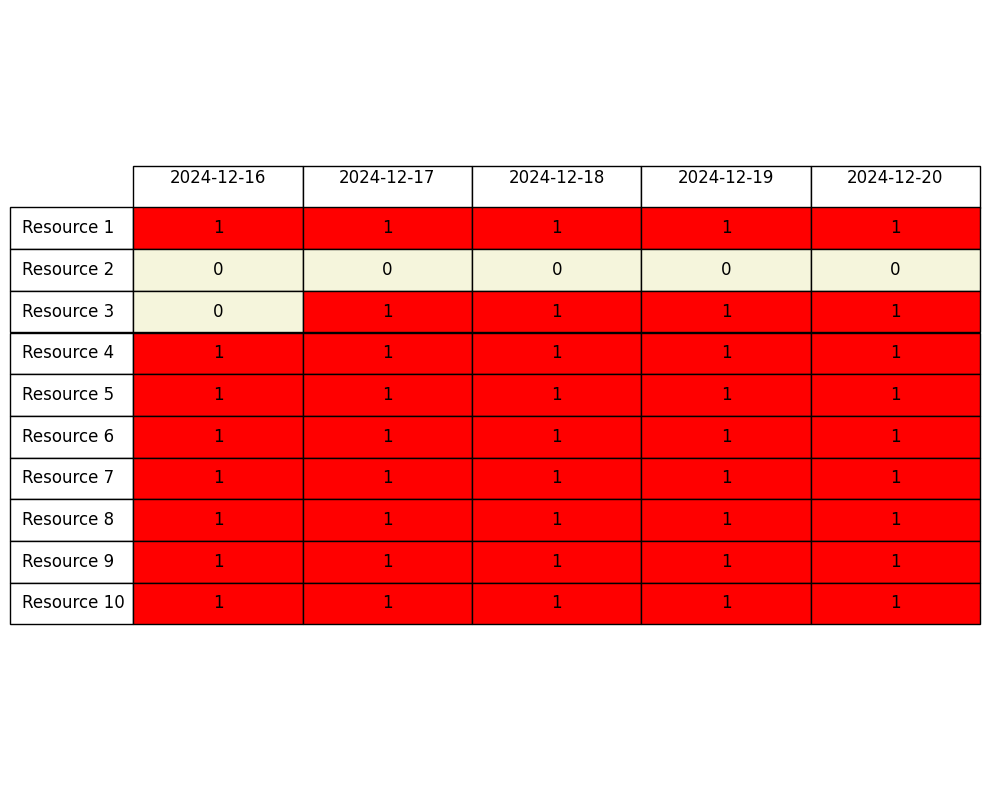

Aggregate Objective Value: 18008.0
Aggregate Best Objective Bound: 18008.0


In [23]:
# Display the table
display_schedule_as_table(all_schedules, resources, date_range)
print('Aggregate Objective Value:', sum([all_diagnostics[pr]['objective_value'] for pr in range(len(all_diagnostics))]))
print('Aggregate Best Objective Bound:', sum([all_diagnostics[pr]['best_objective_bound'] for pr in range(len(all_diagnostics))]))